In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from PIL import ImageOps
from exp import *

In [2]:
from torchvision.utils import save_image

def acc_camvid(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [10]:
model_path = Path('seg_data/train_images')

dm = DatasetManager('2017','224','all','2017')


In [12]:
train_images = dm.get_dataset_path('train_images')
valid_images = dm.get_dataset_path('valid_images')

In [16]:
assert len(train_images.ls()) == 2000
assert len(valid_images.ls()) == 150

In [17]:
learn = load_learner(model_path,file='segmenter_224.pkl')

In [48]:
def reload_dataset(dm,seed=1):
    random_seed(seed,True)
#     tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=0.3,p_affine=1, max_warp=0)
    tfms = [[],[]]
    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name,
                   valid=dm.get_dataset_path('valid_images').name)\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=224)\
    .databunch(bs=16)\
    .normalize(imagenet_stats)
    return data

data = reload_dataset(dm)

### Ejemplo

### experiment with 4 layer imgs 

In [19]:
def tensor_to_gray(t): return t.mean(dim=0).expand(3,t.shape[1],t.shape[2])
def invert_mask(m): return (m + 1) % 2 
def visualize_mask(m): visualize_tensor(m.expand(3,m.shape[1],m.shape[2]) * 255)
def visualize_tensor(t): plt.imshow(t.permute(1, 2, 0))
def mask_color(t,mask):
    coloured_part = (t * mask)
    gray_part = invert_mask(mask) * tensor_to_gray(t)
    return coloured_part+gray_part

### New

In [58]:
data.train_ds[0][0].data

(Image (3, 224, 224), Category seborrheic_keratosis_or_nevus)

In [76]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

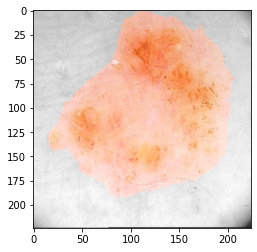

In [88]:
image = data.train_ds[2][0]
mask = learn.predict(image)[1]

def mask_color_keep_orig_size(image_as_tensor,mask_as_int_tensor):
    mask_as_float_tensor = (mask_as_int_tensor*1.0)
    return mask_color(image_as_tensor,mask_as_float_tensor)

masked_image = mask_color_keep_orig_size(image.data,mask)
visualize_tensor(masked_image)

In [91]:
def plot_masked_images(image_index):
    image = data.train_ds[image_index][0]
    mask = learn.predict(image)[1]
    masked_image = mask_color_keep_orig_size(image.data,mask)
    visualize_tensor(masked_image)

In [92]:
interact(plot_masked_images, image_index=widgets.FloatSlider(min=0, max=len(data.train_ds),step=1, continuous_update=False
))

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='image_index', max=2000.0, s…

<function __main__.plot_masked_images(image_index)>

In [250]:
save_image(mask_color_keep_orig_size(data[i].data,mask),'prueba.jpg')

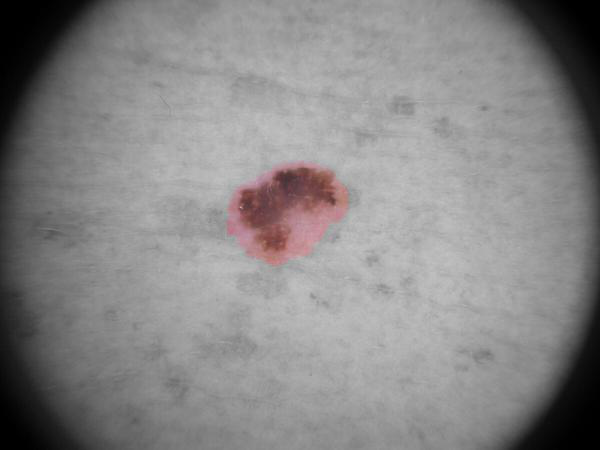

In [251]:
open_image('prueba.jpg')

### OLD

## Procesar todo

In [34]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [35]:
path_segmented_clasif_images_folder = Path('segmented_images_as_284/')
path_segmented_clasif_images_folder.mkdir()
n_of_images = len(data) 

In [37]:
for idx, an_image_to_segment in enumerate(data):
    filename = data.items[idx]
    filepath = filename.parent / path_segmented_clasif_images_folder / filename.name
    if not (filepath.exists()): 
        pred = learn.predict(an_image_to_segment)
        mask = pred[0].data
        tfmd_img = an_image_to_segment.apply_tfms([crop_pad()], size=(284,284), resize_method=ResizeMethod.CROP);
        save_image(mask_color(tfmd_img.data,mask), filepath)
    update_progress(idx / n_of_images)

Progress: [####################] 100.0%


In [101]:
x(path_segmented_clasif_images_folder / data.items[0]).exists()

False

In [11]:
AUROC??